In [1]:
import sys
sys.path.append('NMERFISH')
from ioMicroPostFits import *
from ioMicroN import *

In [2]:
#analysis_folder = r'Z:/Adam/E200_WTC11_WTday3__8_31_2023/AnalysisDeconvolve_CG_fixed_d3'
#finedrifts_folder = r'Z:/Adam/E200_WTC11_WTday3__8_31_2023/best_per_cellComb'

analysis_folder = r'W:\Adam\E217_WTC11_day14_Rad21new\AnalysisDeconvolve_CGBogdanV'
finedrifts_folder = r'W:\Adam\E217_WTC11_day14_Rad21new\AnalysisDeconvolve_CGBogdanV\best_per_cellComb/'

In [3]:
im = read_im(r'W:\Adam\E217_WTC11_day14_Rad21new\H1_RMER_Q1\Conv_zscan__000.zarr')

In [5]:
import napari
V = napari.view_image(im)

In [4]:
def keep_best_per_cell_fastV2(XH_f,nbest=20):
    ###sort molecules by brightness and keep only within cells (CELLs>0)
    XH_f_ = XH_f.copy()
    H = np.nanmean(XH_f_[:,:,-5],axis=1) #brightness
    XH_f_ = XH_f[np.argsort(H)]
    CELLs = np.nanmean(XH_f_[:,:,-1],axis=1).astype(int) #cell index
    keep = CELLs>0
    XH_f_ = XH_f_[keep]
    
    
    #################################
    CELLs = np.nanmean(XH_f_[:,:,-1],axis=1).astype(int) #cell index
    H = np.nanmean(XH_f_[:,:,-5],axis=1) #brightness
    ### find index combining cell id an redout id
    Rs = np.nanmean(XH_f_[:,:,-2],axis=1).astype(int) #region
    
    
    
    
    cellsu = np.unique(CELLs)
    Rsu = np.unique(Rs)
    MR = np.max(Rsu)+1
    mix_index = CELLs*MR+Rs ### unique index combining cell and readout info
    
    #### find the inverse and prealocate space that you fill cyclically
    miu,rinv = np.unique(mix_index,return_inverse=True)
    miu_,cts_ = np.unique(mix_index,return_counts=True)

    
    XH_f_pruned = np.zeros([len(miu),nbest,XH_f.shape[1],XH_f.shape[2]],dtype=XH_f.dtype)+np.nan
    ind_best = np.argsort(np.argsort(rinv))%nbest
    XH_f_pruned[rinv,ind_best,:,:]=XH_f_######
    XH_f_pruned = XH_f_pruned.reshape([-1,XH_f_pruned.shape[-2],XH_f_pruned.shape[-1]])
    good = ~np.all(np.isnan(XH_f_pruned)[:,:,0],axis=1)
    XH_f_pruned = XH_f_pruned[good]
    return XH_f_pruned

In [5]:
gns_names = np.load(r'Z:\Adam\E200_WTC11_WTday3__8_31_2023\best_per_cellComb\loci_names.npy')
XH_fs = np.load(finedrifts_folder+os.sep+r'Conv_zscan__000__XHfs_finedrft.npz')['XH_fs']
XH_fs_ = keep_best_per_cell_fastV2(XH_fs,2)
icodes_ = [inm for inm,nm in enumerate(gns_names) if 'chr10_50297882_50948743' in nm]
keep = np.in1d(np.nanmean(XH_fs_[:,:,-2],axis=1),icodes_)

FileNotFoundError: [Errno 2] No such file or directory: 'W:\\Adam\\E217_WTC11_day14_Rad21new\\AnalysisDeconvolve_CGBogdanV\\best_per_cellComb/\\Conv_zscan__000__XHfs_finedrft.npz'

# Compute the next steps of finding traces based on the decoded candidates

In [3]:
def keep_best_per_cell_fastComb(XH_f,nbest=20):
    ###sort molecules by brightness and keep only within cells (CELLs>0)
    XH_f_ = XH_f.copy()
    H = np.nanmean(XH_f_[:,:,-5],axis=1) #brightness
    XH_f_ = XH_f[np.argsort(H)]
    CELLs = np.nanmean(XH_f_[:,:,-1],axis=1).astype(int) #cell index
    keep = CELLs>0
    XH_f_ = XH_f_[keep]
    
    
    #################################
    CELLs = np.nanmean(XH_f_[:,:,-1],axis=1).astype(int) #cell index
    H = np.nanmean(XH_f_[:,:,-5],axis=1) #brightness
    ### find index combining cell id an redout id
    Rs = np.nanmean(XH_f_[:,:,-2],axis=1).astype(int) #region
    
    cellsu = np.unique(CELLs)
    Rsu = np.unique(Rs)
    MR = np.max(Rsu)+1
    mix_index = CELLs*MR+Rs ### unique index combining cell and readout info
    
    #### find the inverse and prealocate space that you fill cyclically
    miu,rinv = np.unique(mix_index,return_inverse=True)
    miu_,cts_ = np.unique(mix_index,return_counts=True)

    XH_f_pruned = np.zeros([len(miu),nbest,XH_f.shape[1],XH_f.shape[2]],dtype=XH_f.dtype)+np.nan
    ind_best = np.argsort(np.argsort(rinv))%nbest
    XH_f_pruned[rinv,ind_best,:,:]=XH_f_######
    XH_f_pruned = XH_f_pruned.reshape([-1,XH_f_pruned.shape[-2],XH_f_pruned.shape[-1]])
    good = ~np.all(np.isnan(XH_f_pruned)[:,:,0],axis=1)
    XH_f_pruned = XH_f_pruned[good]
    return XH_f_pruned
    
def get_XComb(XH_fsTB,cell,pix=[0.3,0.10833,0.10833]):
    XH_cell = XH_fsTB[XH_fsTB[:,0,-1]==cell]
    hs = np.nanmean(XH_cell[:,:,-5],1)
    Xs = np.nanmean(XH_cell[:,:,:3]*pix,axis=1)
    Rs = XH_cell[:,0,-2]
    icols = XH_cell[:,0,-4]
    return Xs,hs,Rs,icols
def get_X(XH_fsTB,cell,pix=[0.3,0.10833,0.10833]):
    XH_cell = XH_fsTB[XH_fsTB[:,-1]==cell]
    hs = XH_cell[:,-5]
    Xs = XH_cell[:,:3]*pix
    Rs = XH_cell[:,-2]
    icols = XH_cell[:,-4]
    return Xs,hs,Rs,icols
def get_X_cands(self,XH_fs,nchr_=2,pix=[0.300,0.1083,0.1083],
                     radius_chr = 2,radius_cand =3,fr_th=0.4,nelems=2,plt_val = False):
        self.pix = pix
        XH_fsTB = keep_best_per_cell_fastComb(XH_fs,nbest=nelems)
        XH_fsTB = np.nanmean(XH_fsTB,axis=1)
        cells = get_cells(XH_fsTB)
        self.cells = cells
        X_cands = []
        icell_cands = []
        for icell in tqdm(cells):
            Xs,hs,Rs,icols = get_X(XH_fsTB,icell,pix=pix)
            Rs = Rs-np.min(Rs)
            X_chrs = determine_number_of_chromosomes(Xs,hs,Rs,nchr_=nchr_,radius_chr = radius_chr,fr_th=fr_th,plt_val=False)
            
            
            if len(X_chrs)>0:
                XH_fs_ = np.nanmean(XH_fs,axis=1)
                Xs,hs,Rs,icols = get_X(XH_fs_,icell,pix=pix)
                Rs = Rs-np.min(Rs)
                mat = cdist(X_chrs,Xs)
                nchr = len(X_chrs)
                best_asign = np.argmin(mat,axis=0)

                for ichr in range(nchr):
                    keep = (best_asign==ichr)&(mat[ichr]<radius_cand)
                    X_cands_ = np.array([Xs[keep,0],Xs[keep,1],Xs[keep,2],hs[keep],hs[keep],icols[keep],Rs[keep]]).T
                    X_cands.append(X_cands_)
                    icell_cands.append(icell)

        self.X_cands =X_cands
        self.icell_cands=icell_cands


        print("Detected number of chromosomes:" + str(len(self.icell_cands)))
        ploidy,ncells = np.unique(np.unique(self.icell_cands,return_counts=True)[-1],return_counts=True)
        for pl,nc in zip(ploidy,ncells):
            print("Number of cells with "+str(pl) +" chromosomes: "+str(nc))
class Dummy:
    pass
dummy = Dummy()

In [4]:
gene_names = np.load(r'Z:\Adam\E200_WTC11_WTday3__8_31_2023\best_per_cellComb\loci_names.npy')
dic_chrs = {}
for ign,gn_name in enumerate(gene_names):
    if 'blank' not in gn_name:
        loc_nm = '_'.join(gn_name.split('_')[:3])
        if loc_nm not in dic_chrs: dic_chrs[loc_nm]=[]
        dic_chrs[loc_nm].append(ign)

In [7]:
fls = glob.glob(finedrifts_folder+os.sep+r'*finedrft.npz')

In [ ]:
overwrite=False

gns_names = np.load(r'Z:\Adam\E200_WTC11_WTday3__8_31_2023\best_per_cellComb\loci_names.npy')
all_regions = np.unique([ gn.split("__")[0][:-10] for gn in gns_names ])[1:]

# go through all regions one at a time of the DNA
for region in tqdm(all_regions[:]):
    print("Compiling all FOVs for region", region)
    # go through all FOVs one at a time for each region.
    region_tag = region
    for element in tqdm(fls):

        save_flf= element.replace('.npz','_'+region_tag+'_traces.npz')
        print("Saving to:",save_flf)
        
        if os.path.exists(save_flf) and not overwrite:
            print(save_flf+" already completed, skipping.")
            continue
            
        XH_fso = np.load(element)['XH_fs']
        cp=Dummy()
        XH_fs = XH_fso.copy()
        Rs = XH_fs[:,0,-2]#.astype(int)
        ind_Rs = dic_chrs[region_tag]
        keep = np.in1d(Rs,ind_Rs)
        XH_fs=XH_fs[keep]
        Rs = XH_fs[:,0,-2]
        XH_fs[:,0,-2]=Rs-np.min(Rs)
        get_X_cands(cp,keep_best_per_cell_fastComb(XH_fs,10),nchr_=3,pix=[0.300,0.1083,0.1083],  # 10 is the top number of candidates per cell
                    radius_chr = 2,radius_cand =2.,fr_th=0.35,nelems=3,plt_val = False) ################### nelems - the number of spots per cell conisdered for homolog separation
        Rs = np.unique(XH_fs[:,0,-2])
        uRs = np.arange(np.max(Rs)+1).astype(int)#np.unique(Rs).astype(int)
        initialize_with_max_brightness(cp,nkeep = 8000,Rs_u = uRs)
        normalize_color_brightnesses(cp)
        run_EM(cp,nkeep = 80000,niter = 4,Rs_u = uRs)
        get_scores_and_threshold(cp,th_score = -2.5)
        #plot_matrix(cp,th_score=-2.5,lazy_color_correction = False,vmin=0,vmax=1.5)
        plt.show()
        
        cells = cp.icell_cands
        def get_fov(fl): return int(os.path.basename(fl).split('__X')[0].split('__')[-1])
        ifov = get_fov(element)
        cells_f = np.array(cells)+ifov*10**5
        
        np.savez(save_flf,zxys_f = cp.zxys_f,hs_f = cp.hs_f,cells_f=cells_f,scores_f=cp.scores_f)
        print("Final Selection complete for", element)

In [8]:
all_fls = glob.glob(finedrifts_folder+os.sep+r'*_XHfs_finedrft_c*.npz')
fls_trim = np.unique([fl.split("__X")[1] for fl in all_fls])
locs = [i[13:].split("_t")[0] for i in fls_trim]
for loc in locs:
    trace_fls = glob.glob(finedrifts_folder+os.sep+r'*_XHfs_finedrft_'+loc+'_traces.npz')
    print(loc+": "+str(len(trace_fls))+" FOVs completed.")

chr10_50297882_50948743: 302 FOVs completed.
chr11_22408906_22969049: 302 FOVs completed.
chr12_75004739_75484764: 302 FOVs completed.
chr17_28708688_29359137: 302 FOVs completed.
chr19_1202064_1844826: 302 FOVs completed.
chr19_3708256_4213167: 302 FOVs completed.
chr19_37547865_38078198: 302 FOVs completed.
chr1_196891040_197431282: 302 FOVs completed.
chr1_68955457_69504871: 302 FOVs completed.
chr20_38815572_39295315: 302 FOVs completed.
chr2_165422331_165922285: 302 FOVs completed.
chr2_185057219_185537559: 302 FOVs completed.
chr2_28976364_29446381: 302 FOVs completed.
chr3_199135617_199702565: 302 FOVs completed.
chr4_149682600_150182502: 302 FOVs completed.
chr4_83436934_83946704: 302 FOVs completed.
chr5_174406074_174886658: 302 FOVs completed.
chr6_89108309_89608298: 302 FOVs completed.
chr7_20125023_20755624: 302 FOVs completed.
chr8_113098273_113597929: 302 FOVs completed.
chr8_144292244_144677239: 302 FOVs completed.
chr8_145231416_145720916: 302 FOVs completed.
chr8_79992

In [9]:
loc = locs[-1]
loc = 'chr10_50297882_50948743'
trace_fls = glob.glob(finedrifts_folder+os.sep+r'*_XHfs_finedrft_'+loc+'_traces.npz')
len(trace_fls)#1

302

In [10]:
zxys_f,scores_f = None,None#2
size = None
for tr_fl in trace_fls:
    dic_ = np.load(tr_fl)
    zxys_f_ = dic_['zxys_f']
    scores_f_ = dic_['scores_f']
    
    if size != None and zxys_f_.shape[1] != size:
        continue
    zxys_f = zxys_f_ if zxys_f is None else np.concatenate([zxys_f,zxys_f_])
    size = zxys_f.shape[1]
    scores_f = scores_f_ if scores_f is None else np.concatenate([scores_f,scores_f_])

C:\Users\cfg001\AppData\Local\Temp\ipykernel_10724\3912496647.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


chr10_50297882_50948743
chr10_50297882_50948743


(26508, 62, 62)

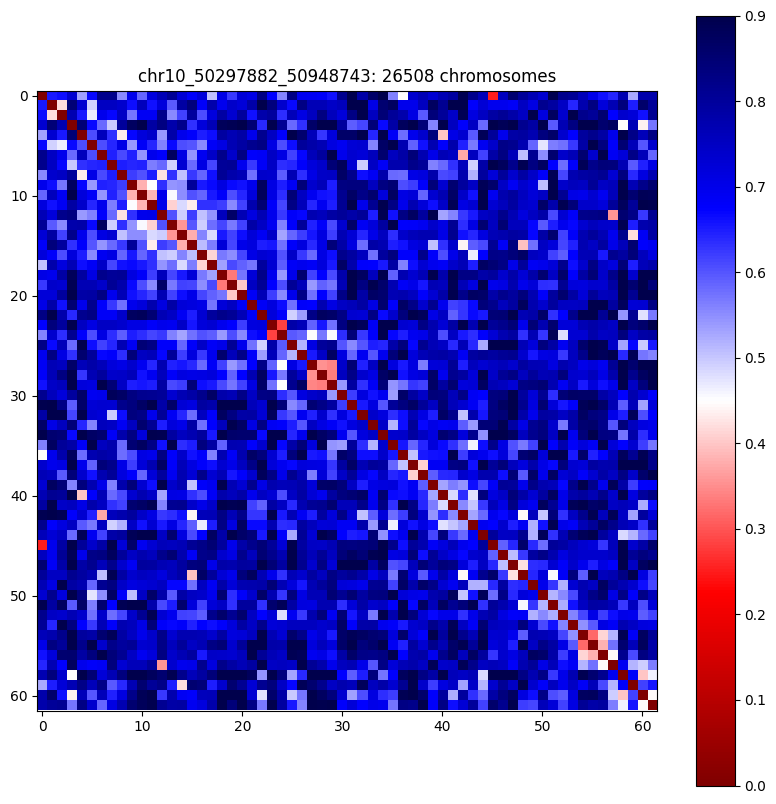

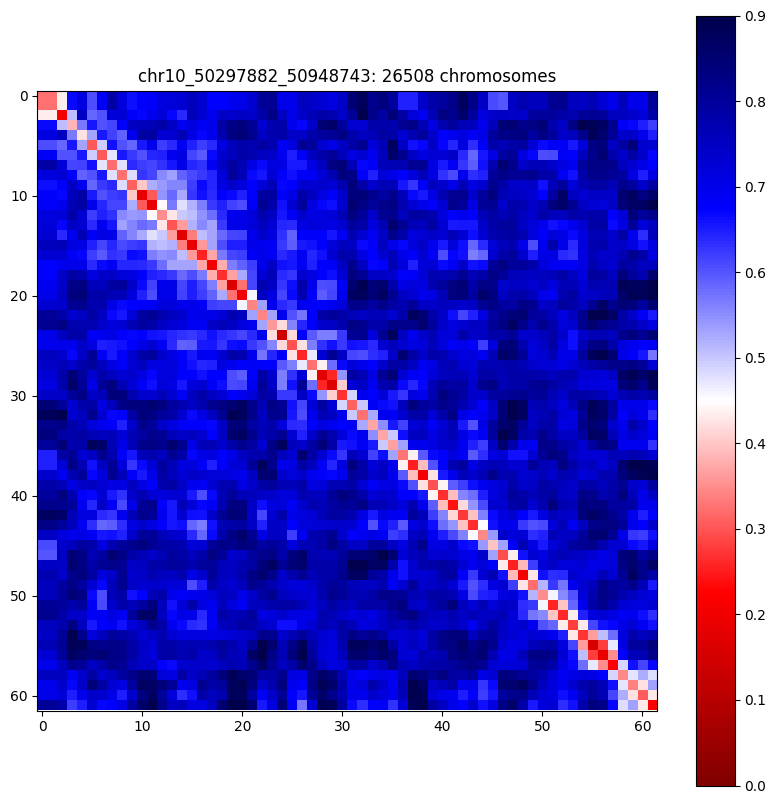

In [13]:
from scipy.ndimage.filters import gaussian_filter 
th_score = -1.2
Xf = np.array(zxys_f)
bad = np.log(scores_f)<th_score
Xf[bad] = np.nan

if False: ### correct chromatic abberation (lazy)
    ncol=3
    cm = np.nanmean(Xf[:,:,:],axis=1)[:,np.newaxis]
    for icol in range(ncol):
        Xf[:,icol::ncol,:]-=np.nanmedian(Xf[:,icol::ncol,:],axis=1)[:,np.newaxis]+cm

from scipy.spatial.distance import pdist,squareform
mats = np.array([squareform(pdist(X_)) for X_ in Xf])

plt.figure(figsize=(10,10))
keep = np.arange(mats.shape[1])#[icol::3]
print(loc)
plt.title(loc+': '+str(Xf.shape[0])+' chromosomes')
plt.imshow(np.nanmedian(mats[:,keep][:,:,keep],0),vmax=0.9,vmin=0.0,cmap='seismic_r')
plt.colorbar()


plt.figure(figsize=(10,10))
keep = np.arange(mats.shape[1])#[icol::3]
print(loc)
plt.title(loc+': '+str(Xf.shape[0])+' chromosomes')
median_mat = np.nanmedian(mats[:,keep][:,:,keep],0)
median_mat[np.where(np.isnan(median_mat))] = np.nanmedian(np.ravel(median_mat))
smoothed_image = cv2.blur(median_mat, (2,2))
smoothed_image[np.where(np.isnan(smoothed_image))] = np.nanmedian(mats,0)[np.where(np.isnan(smoothed_image))]
plt.imshow(smoothed_image, vmax=0.9,vmin=0.0,cmap='seismic_r')
plt.title(loc+': '+str(mats.shape[0])+' chromosomes')
plt.colorbar()
mats.shape#3

0.06533572336044627

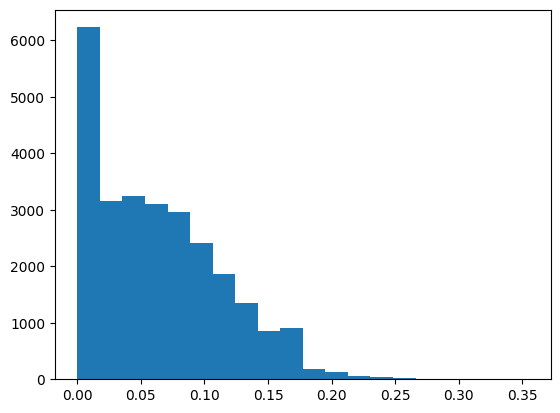

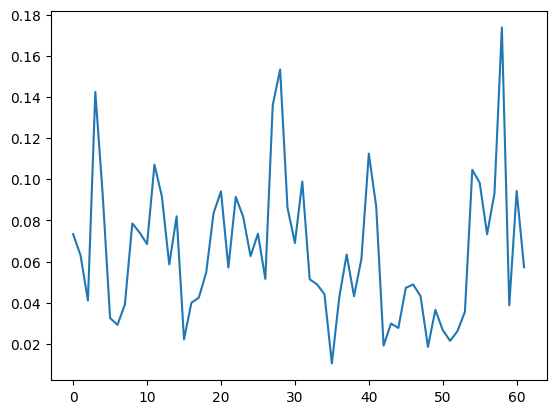

In [16]:
det_eff_per_chr = (1-np.mean(np.isnan(Xf[:,:,-1]),axis=-1))
plt.figure()
plt.hist(det_eff_per_chr,bins=20)

plt.figure()
det_eff_per_rnd = (1-np.mean(np.isnan(Xf[:,:,-1]),axis=0))
plt.plot(det_eff_per_rnd)
np.mean(det_eff_per_rnd)

chr10_50297882_50948743


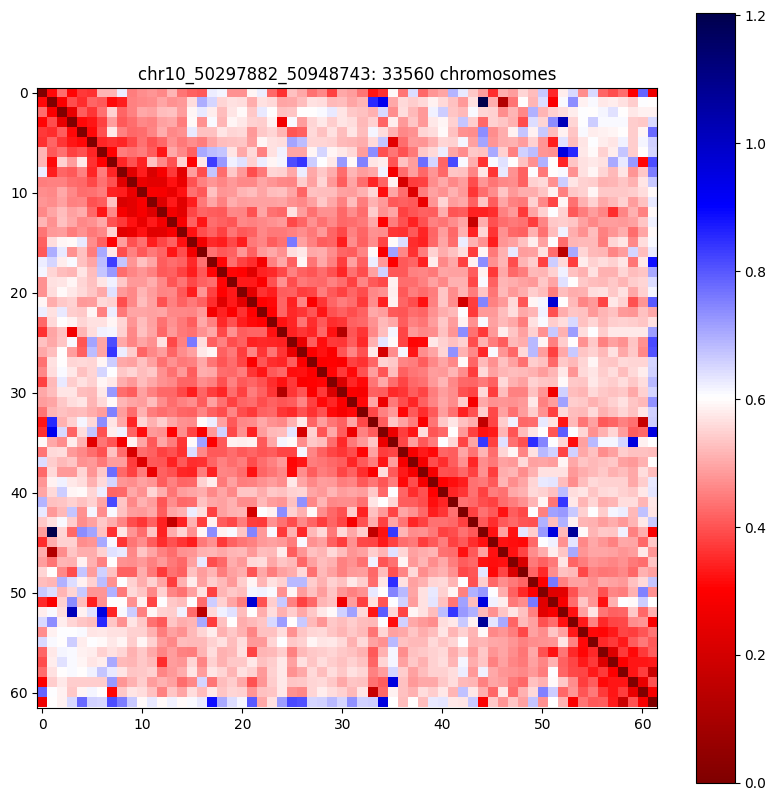

chr11_22408906_22969049


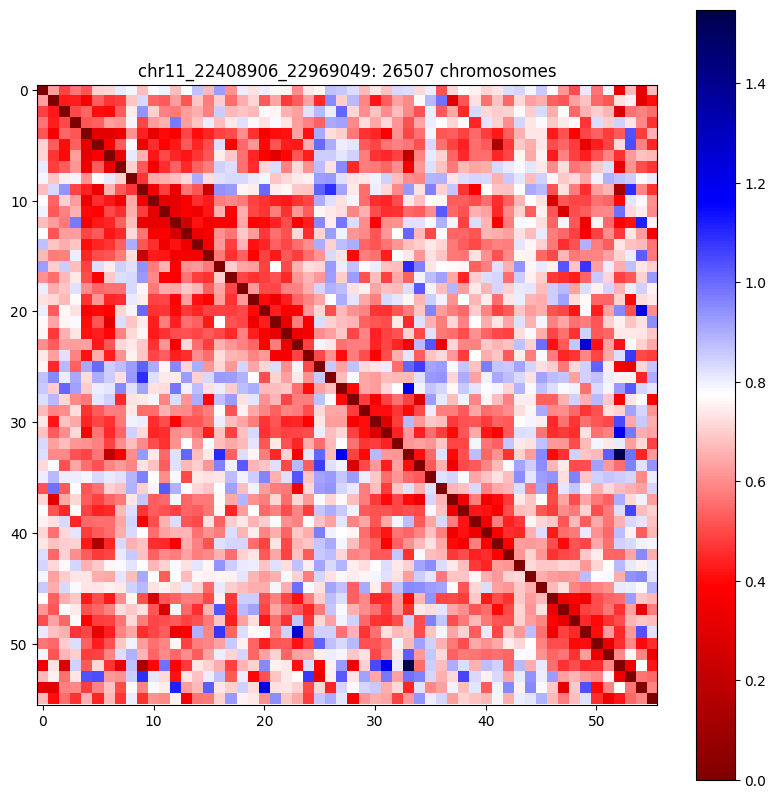

chr12_75004739_75484764


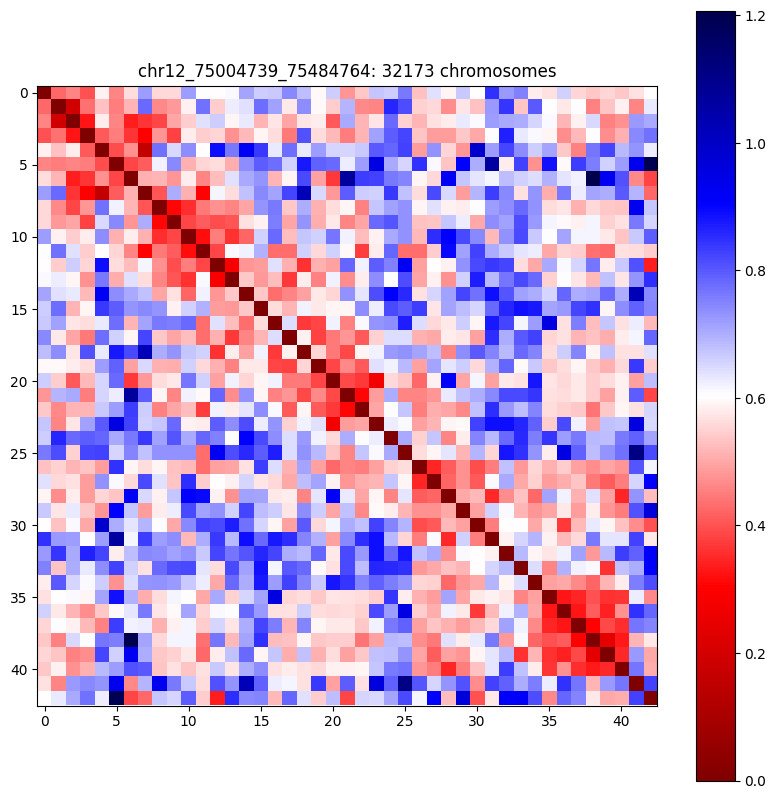

chr17_28708688_29359137


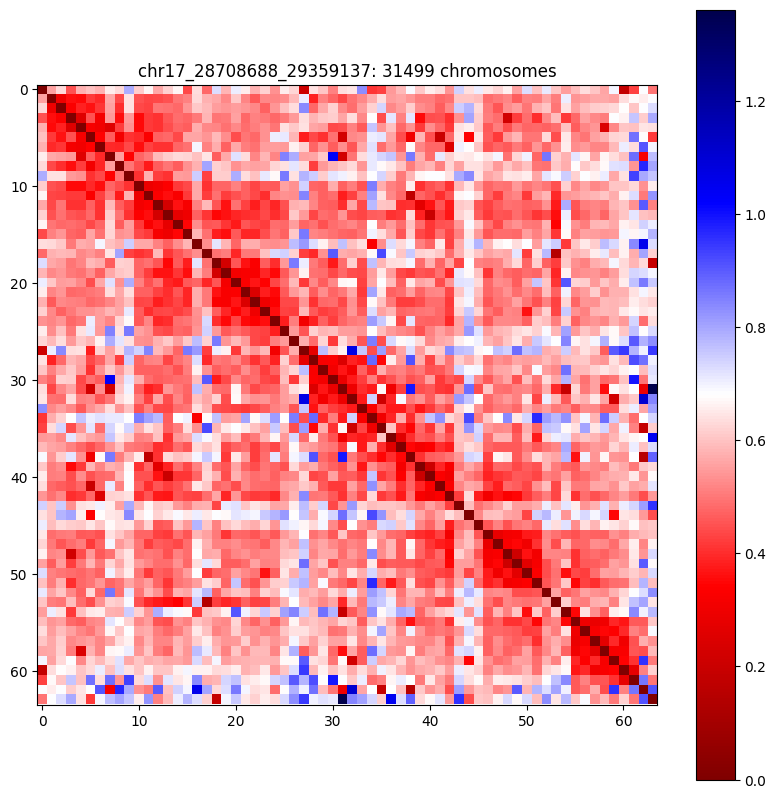

chr19_1202064_1844826


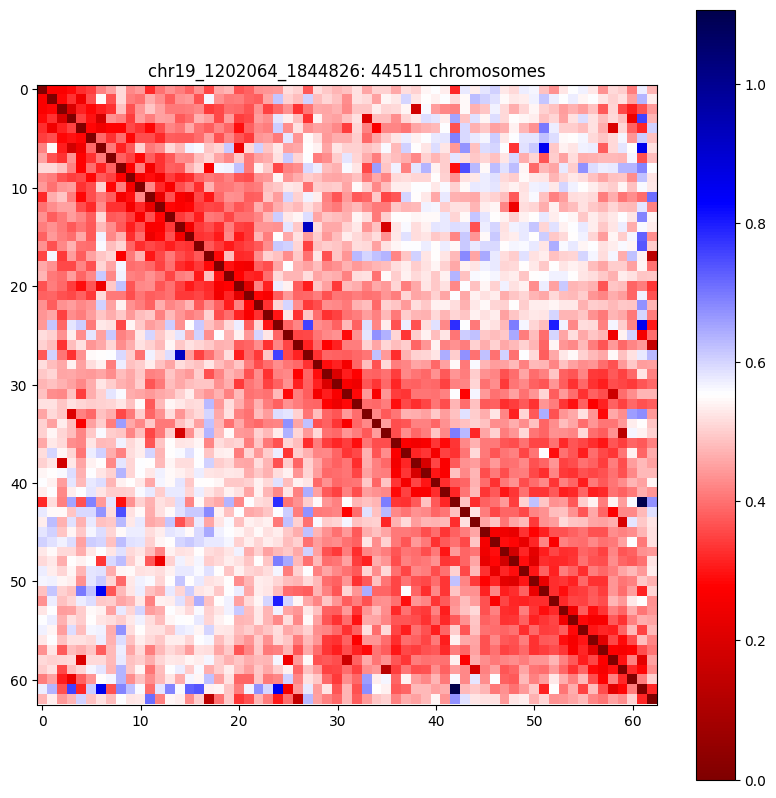

chr19_3708256_4213167


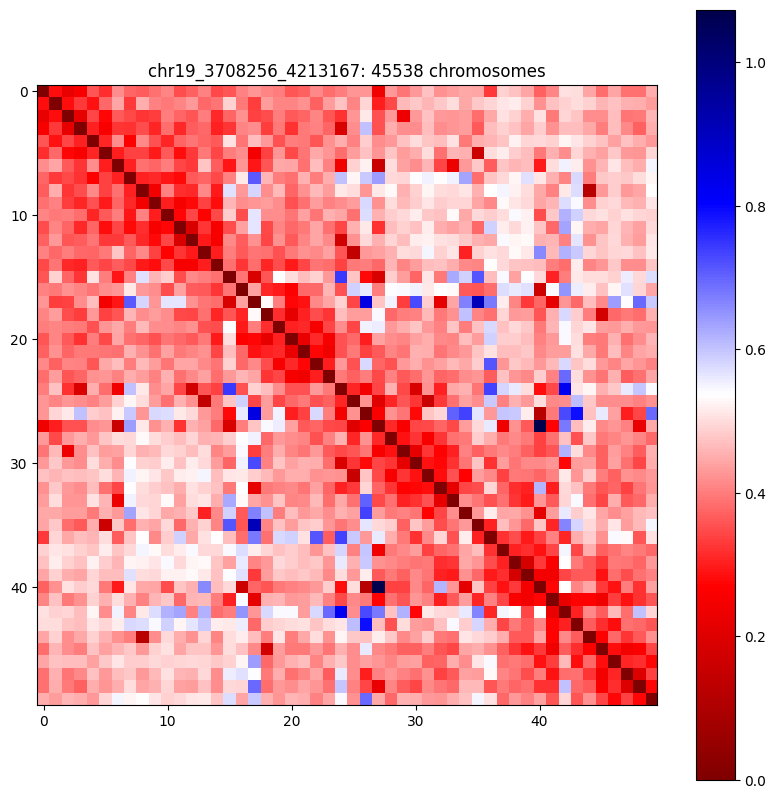

chr19_37547865_38078198


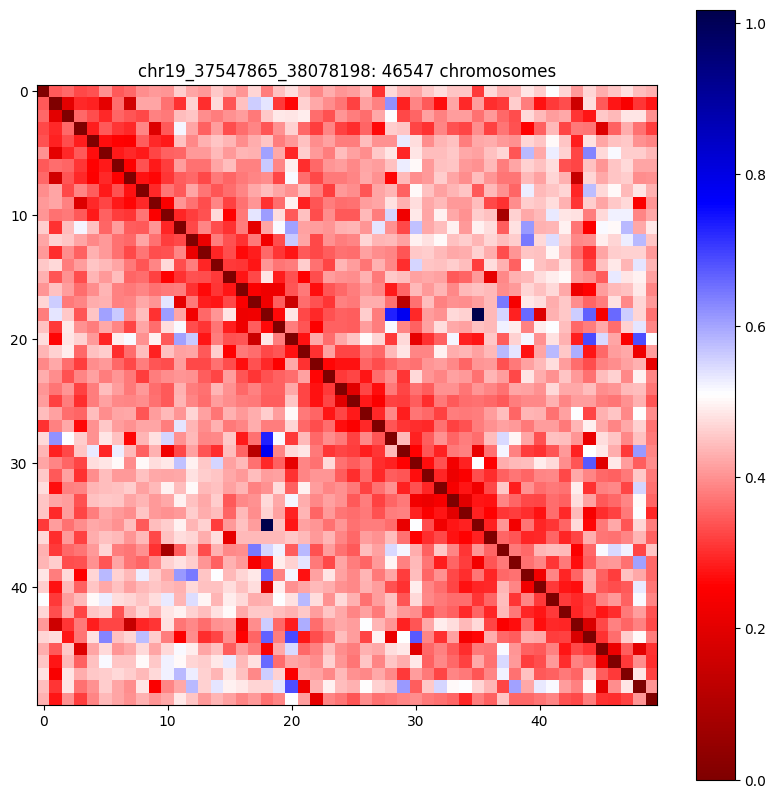

chr1_196891040_197431282


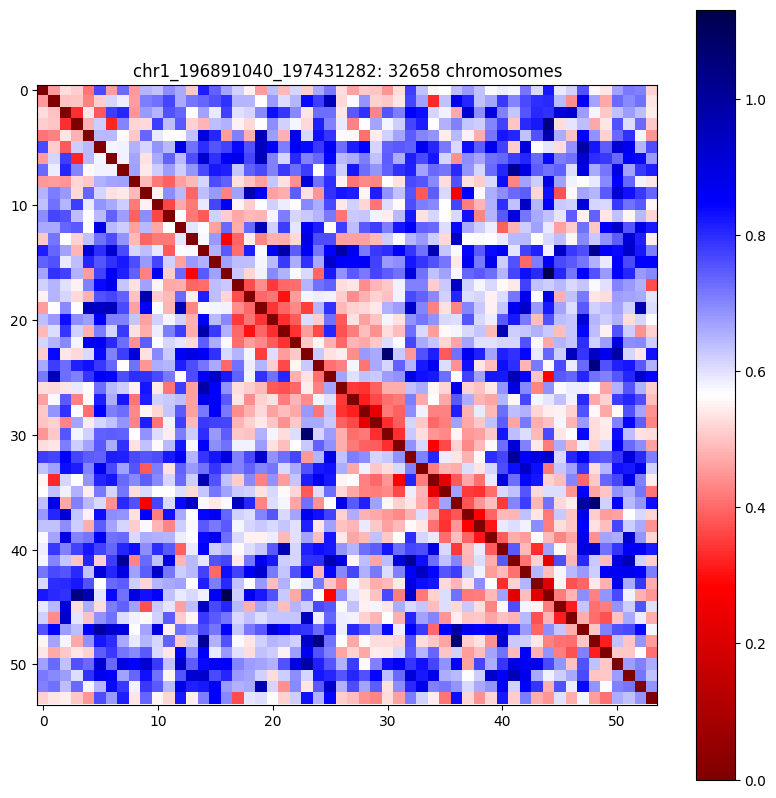

chr1_68955457_69504871


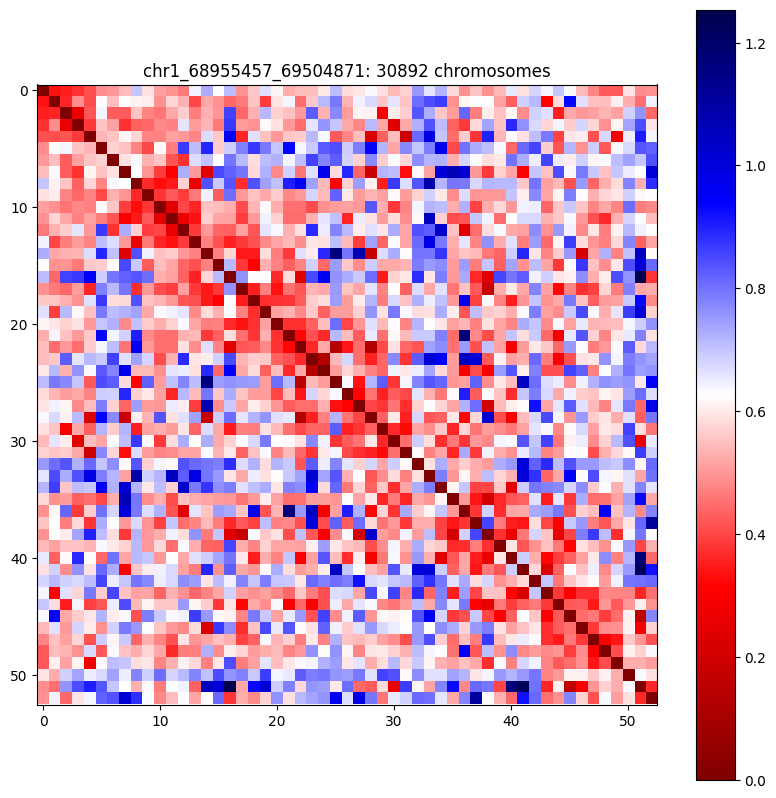

chr20_38815572_39295315


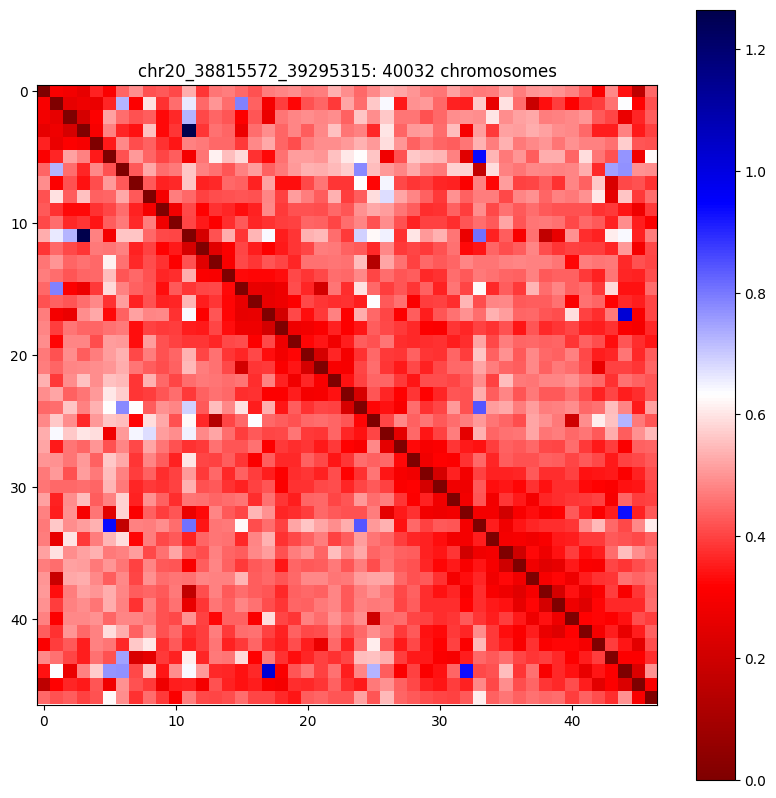

chr2_165422331_165922285


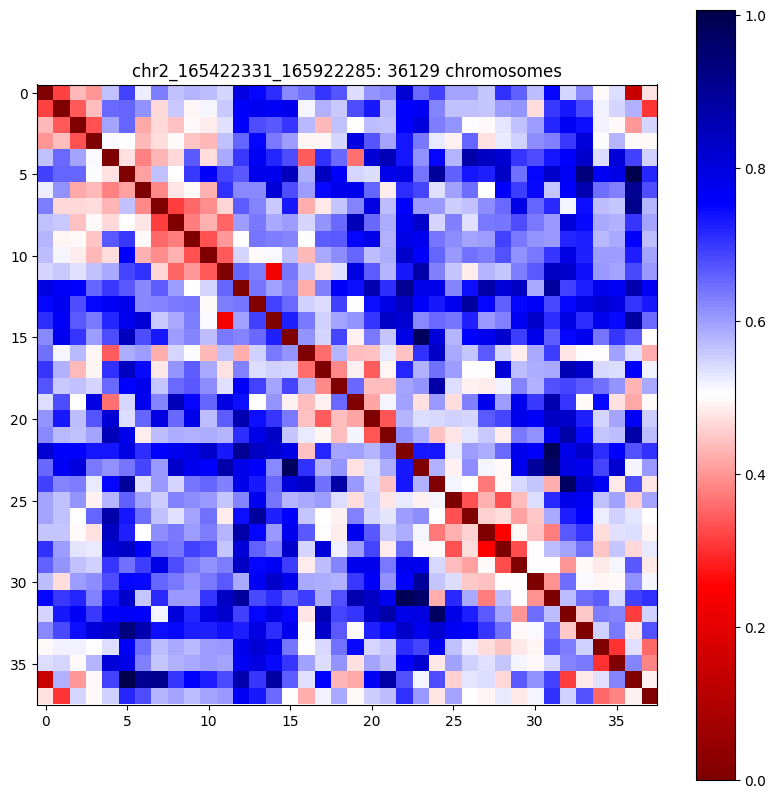

chr2_185057219_185537559


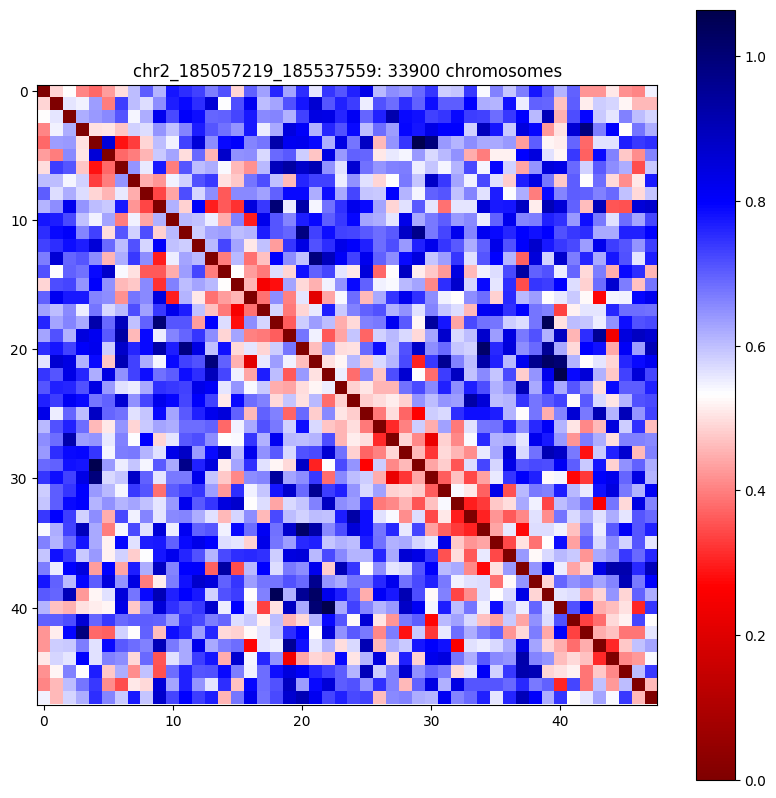

chr2_28976364_29446381


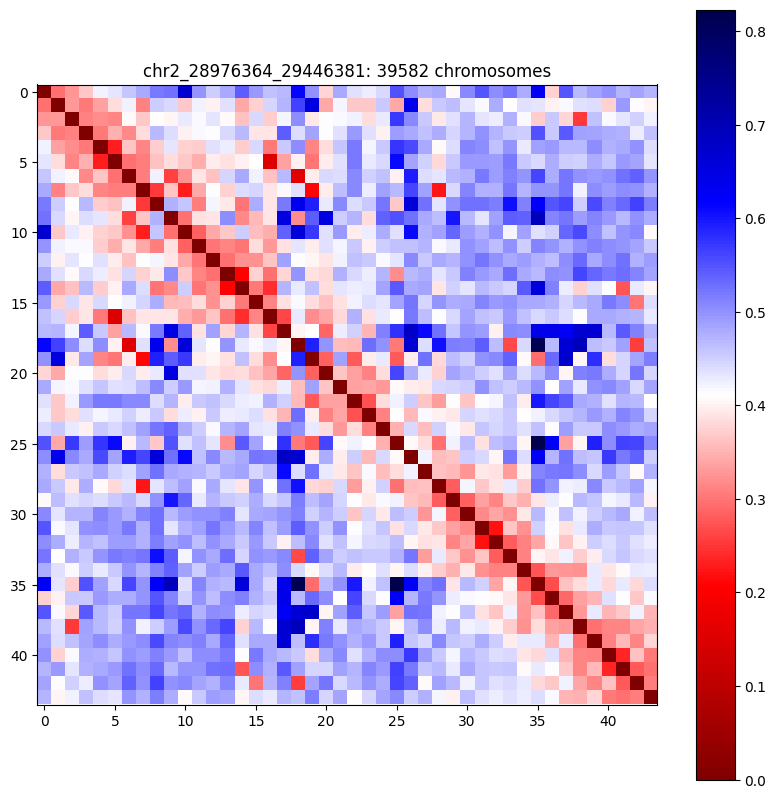

chr3_199135617_199702565


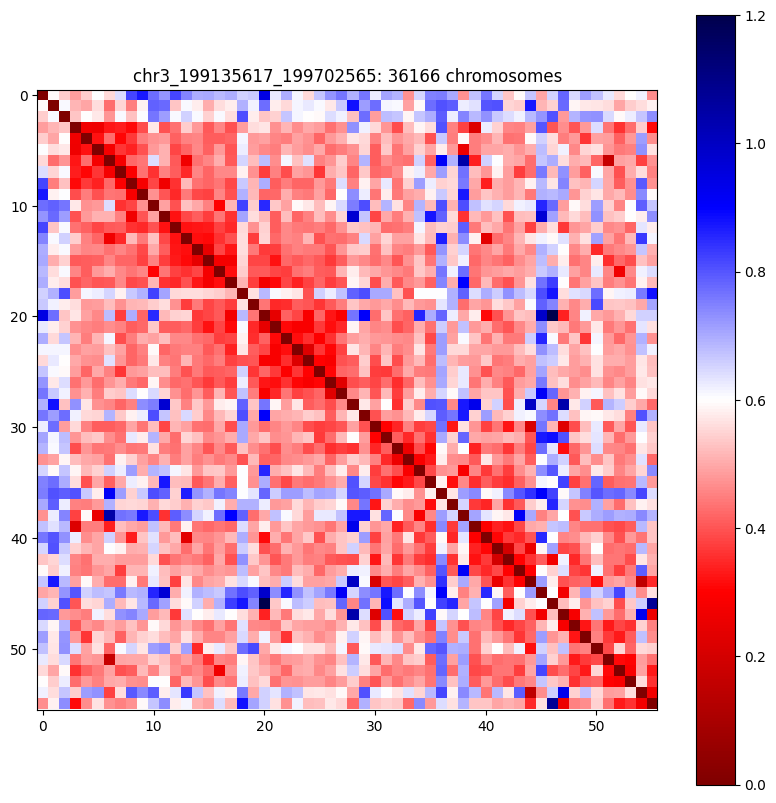

chr4_149682600_150182502


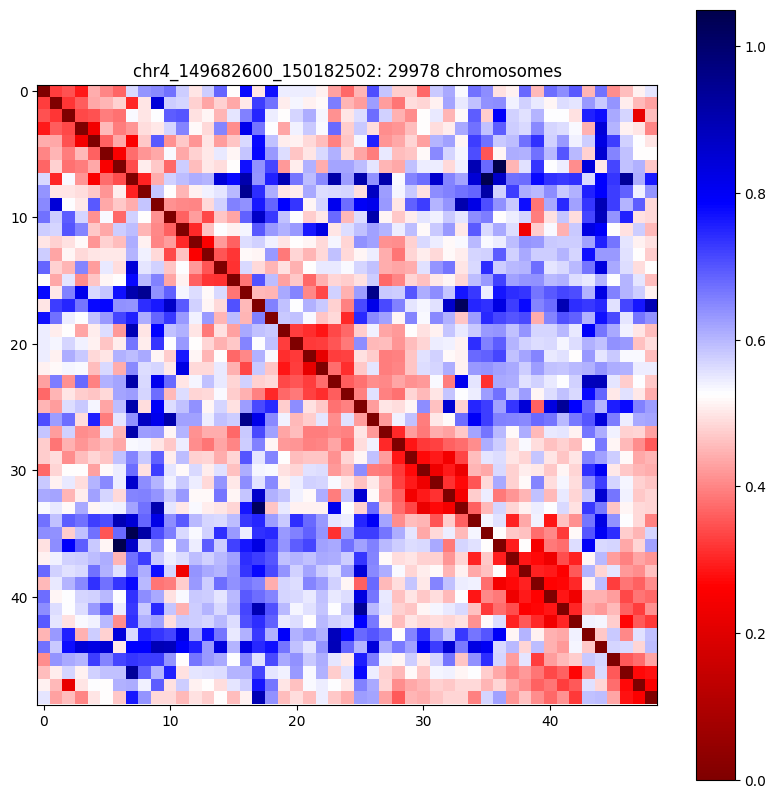

chr4_83436934_83946704


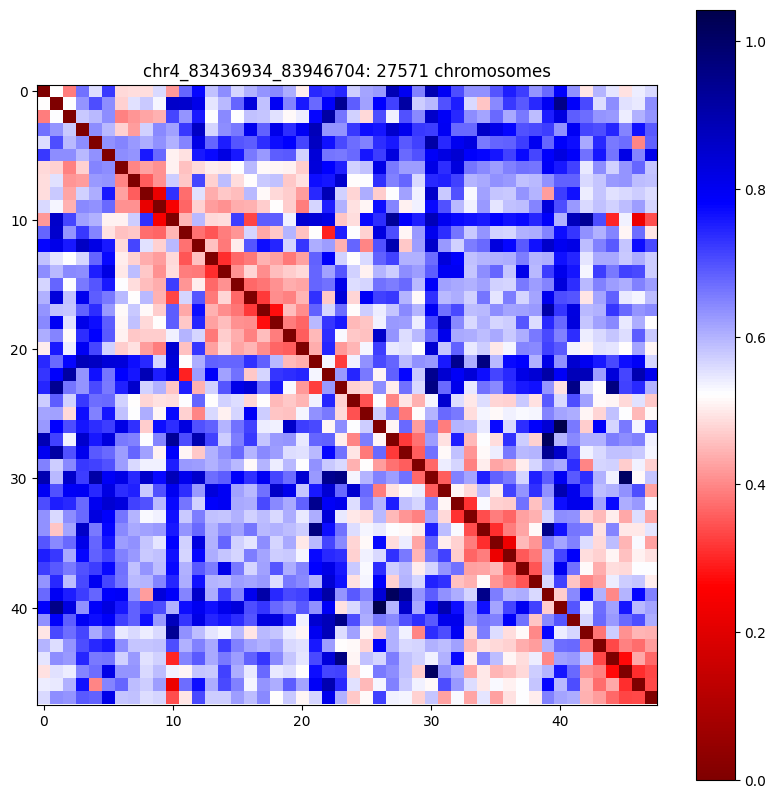

chr5_174406074_174886658


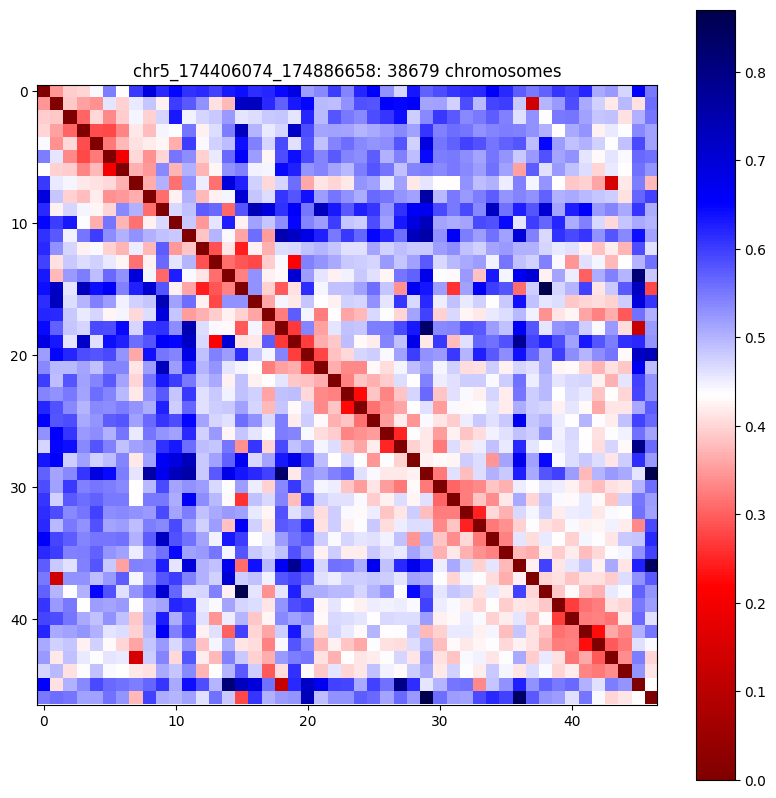

chr6_89108309_89608298


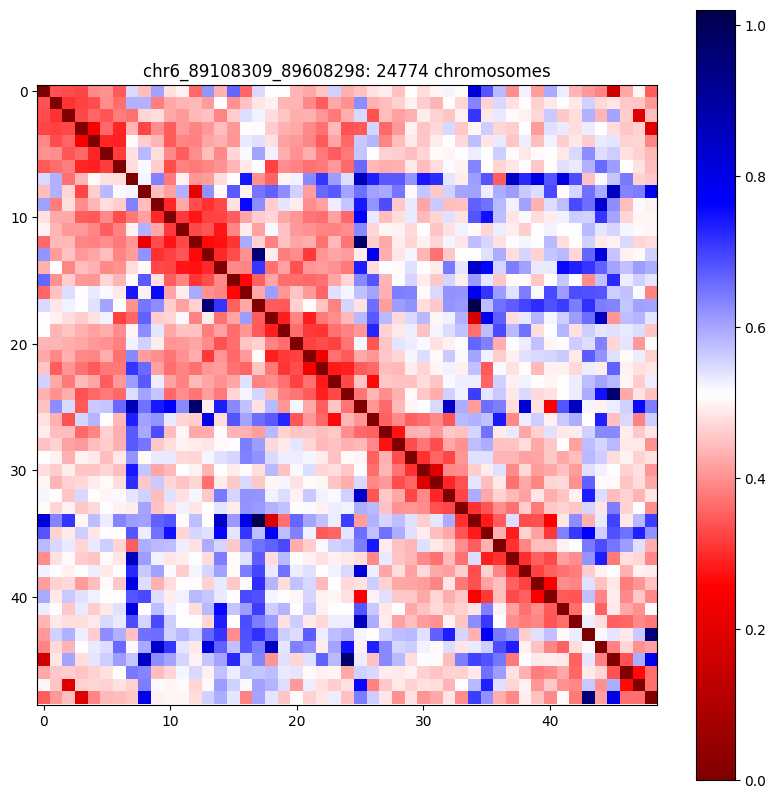

chr7_20125023_20755624


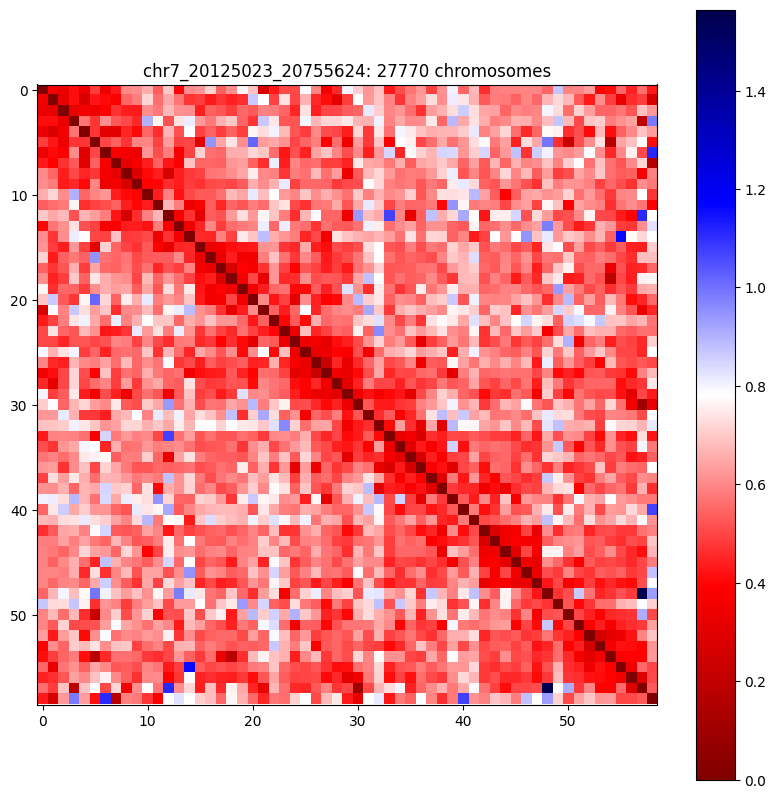

chr8_113098273_113597929


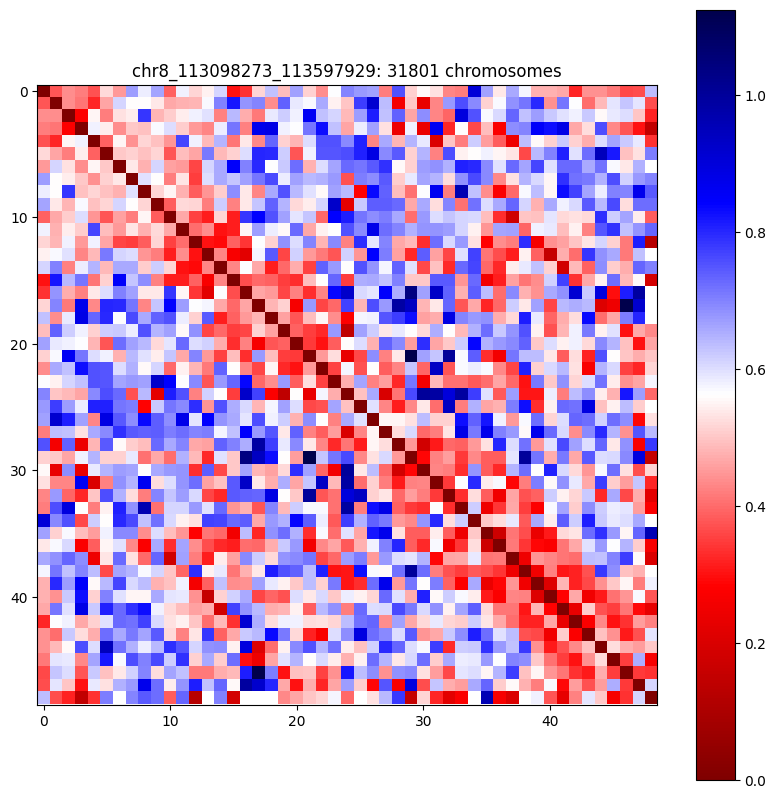

chr8_144292244_144677239


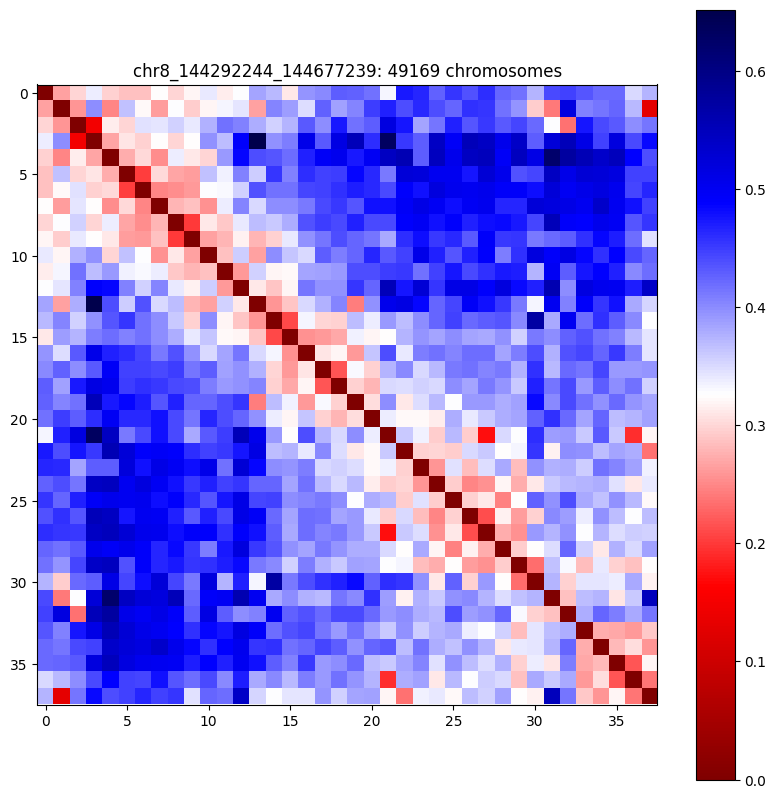

chr8_145231416_145720916


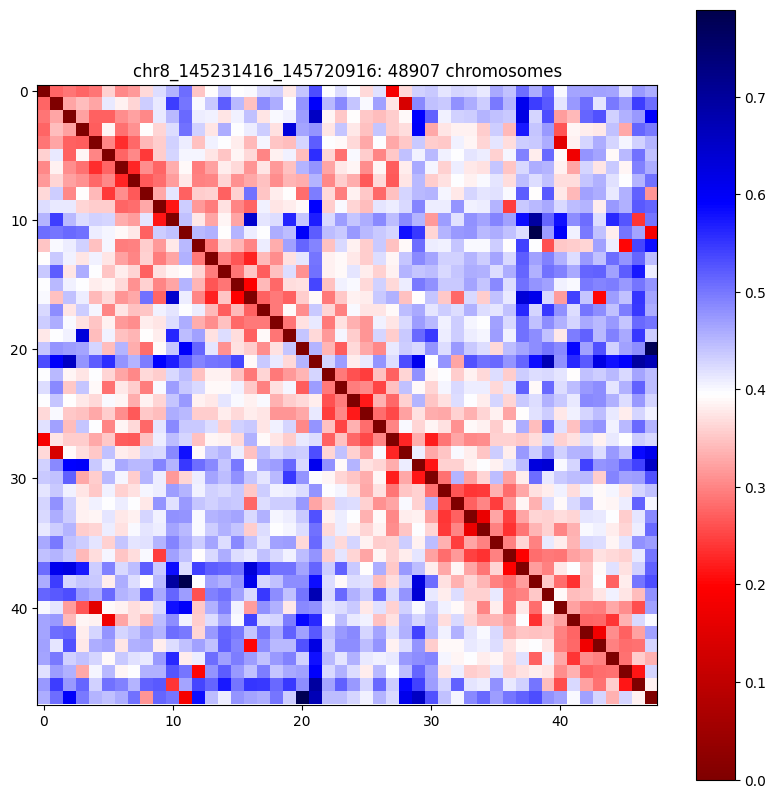

chr8_79992471_80482456


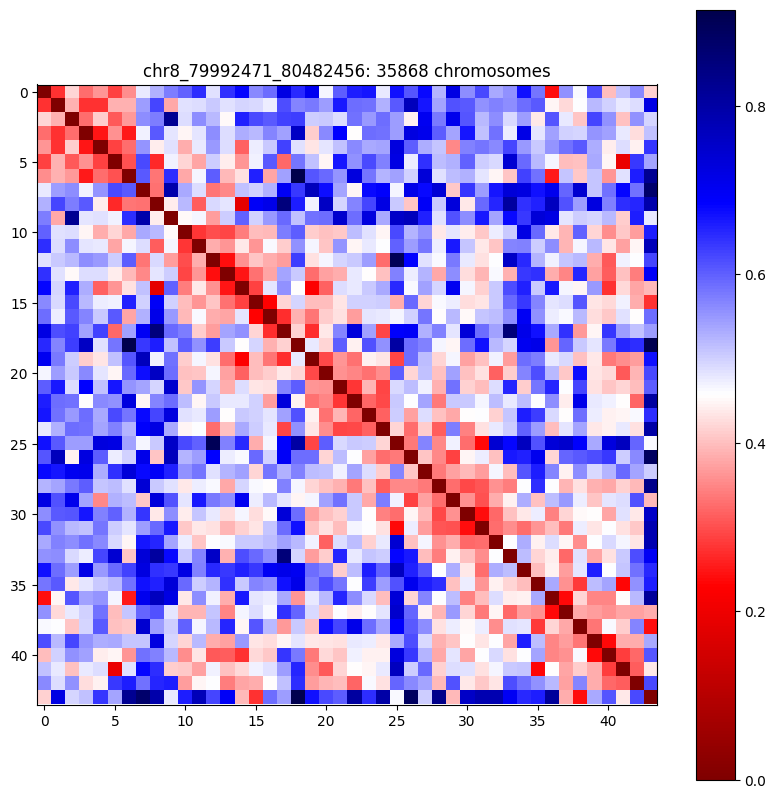

chr9_37910438_38580724


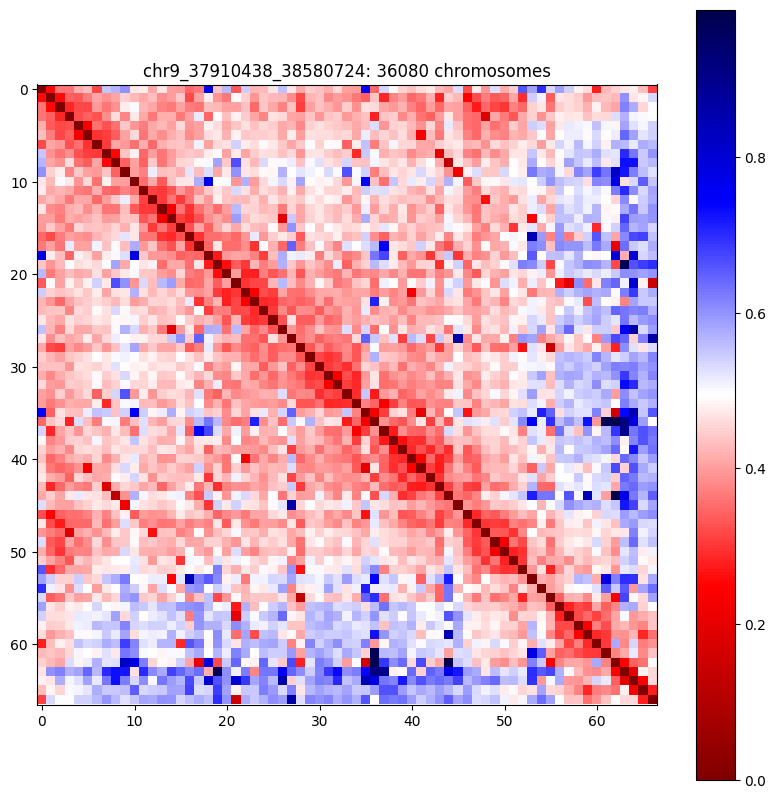

chrX_109291856_109931988


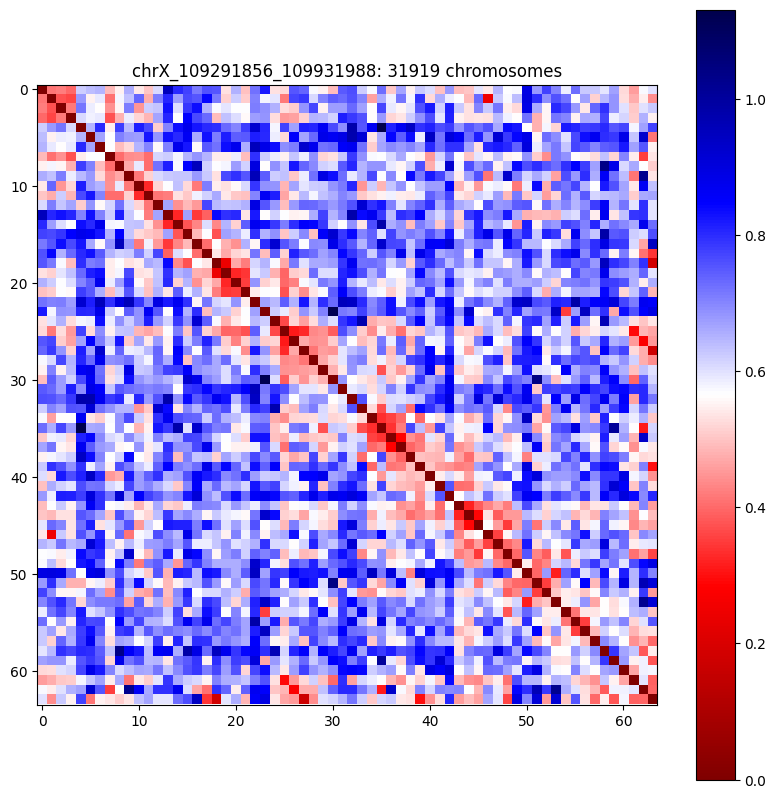

In [17]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

if not os.path.exists(finedrifts_folder+os.sep+r'heatmaps'):
    os.mkdir(finedrifts_folder+os.sep+r'heatmaps')

for loc in locs[:]:
    trace_fls = glob.glob(finedrifts_folder+os.sep+r'*_XHfs_finedrft_'+loc+'_traces.npz')
   
    zxys_f, scores_f = None, None
    for tr_fl in trace_fls:
        dic_ = np.load(tr_fl)
        zxys_f_ = dic_['zxys_f']
        scores_f_ = dic_['scores_f']
        zxys_f = zxys_f_ if zxys_f is None else np.concatenate([zxys_f, zxys_f_])
        scores_f = scores_f_ if scores_f is None else np.concatenate([scores_f, scores_f_])
        
    Xf = np.array(zxys_f)
    bad = np.log(scores_f) < th_score
    Xf[bad] = np.nan
    
    if False:  # correct chromatic aberration (lazy)
        ncol = 3
        cm = np.nanmean(Xf[:, :, :], axis=1)[:, np.newaxis]
        for icol in range(ncol):
            Xf[:, icol::ncol, :] -= np.nanmedian(Xf[:, icol::ncol, :], axis=1)[:, np.newaxis] + cm
    
    from scipy.spatial.distance import pdist, squareform
    mats = np.array([squareform(pdist(X_)) for X_ in Xf])
    
    plt.figure(figsize=(10, 10))
    keep = np.arange(mats.shape[1])
    print(loc)
    plt.imshow(np.nanmedian(mats[:, keep][:, :, keep], 0), cmap='seismic_r')#, vmax=.8, vmin=0.2)
    plt.colorbar()
    plt.title(loc + ': ' + str(mats.shape[0]) + ' chromosomes')
    saveloc = finedrifts_folder+os.sep+'heatmaps'+os.sep+loc+'_heatmap.png'
    plt.savefig(saveloc, dpi=600)
    np.save(saveloc.replace('heatmap.png', 'traces.npy'), mats[:, keep][:, :, keep])
    np.save(saveloc.replace('.png', '.npy'), np.nanmedian(mats[:, keep][:, :, keep], 0))
    plt.show()
    

In [ ]:
X = XH_fs_[keep]
Xc = np.nanmean(X[:,:,:3],axis=1)
Xc.shape

In [ ]:
np.max(Xc,axis=0)

In [ ]:
import napari
V = napari.view_points(Xc,size=2)

<h3> This code is to look at cluster label associations and their respective chromatin structures using a set of labels taken from scanpy in the scanpy_clustering_rna.ipynb </h3>

In [13]:
# splicing out the cell ids for each cluster respectively
clusters = np.load(r'Z:\Adam\E201_WTC11_WTday15__10_20_2023\AnalysisDeconvolve_CG_fixed_d14\RNA_exons\leiden_ids_cids_pairs_neurons.npy')
largest = max([int(c) for c in clusters[:,1]])

cluster_locs = {}

for cluster in range(largest):
    cluster_locs[cluster] = clusters[clusters[:,1] == str(cluster),0]

15704


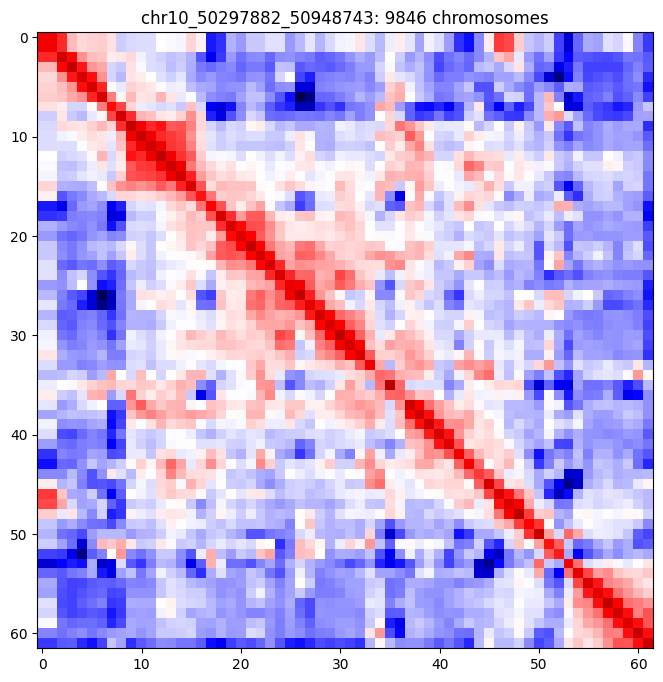

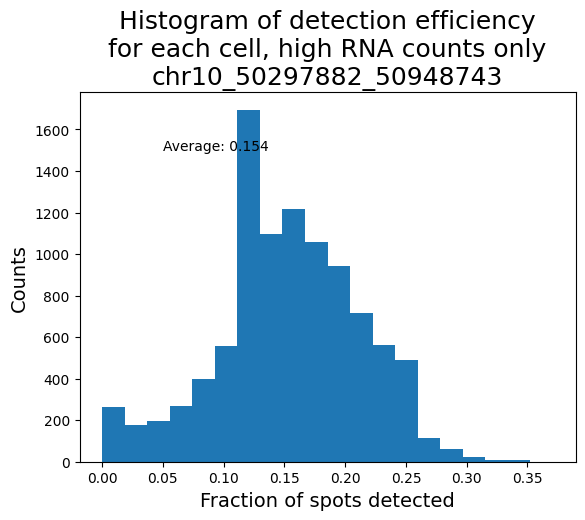

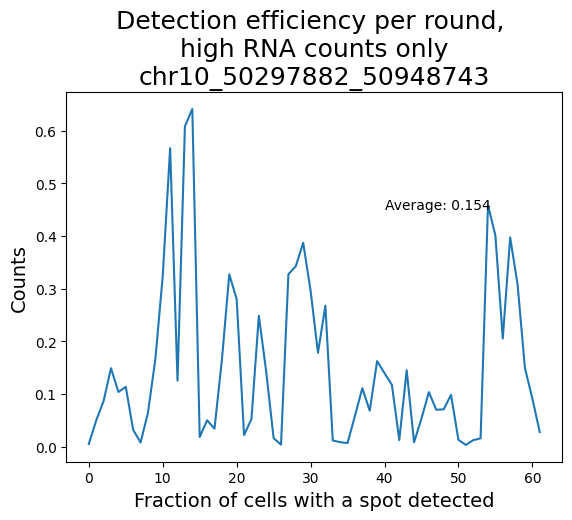

In [14]:
from scipy.spatial.distance import pdist,squareform

# load in the aggregate heatmap
th_score = -1.2
cids = clusters[:,0]
print(len(cids))

for loc in locs[0:1]:
    
    trace_fls = glob.glob(finedrifts_folder+os.sep+r'*_XHfs_finedrft_'+loc+'_traces.npz')
    size = None
    zxys_f,scores_f, cids_f = None,None,None
    for tr_fl in trace_fls:
        dic_ = np.load(tr_fl)
        zxys_f_ = dic_['zxys_f']
        scores_f_ = dic_['scores_f']
        
        if size != None and zxys_f_.shape[1] != size:
            continue
        zxys_f = zxys_f_ if zxys_f is None else np.concatenate([zxys_f,zxys_f_])
        size = zxys_f.shape[1]
        scores_f = scores_f_ if scores_f is None else np.concatenate([scores_f,scores_f_])
        cids_f_ = dic_['cells_f']
        cids_f_ = [ str(int(x)//100000)+'_'+str(int(x)%100000) for x in cids_f_ ]
        cids_f = cids_f_ if cids_f is None else np.concatenate([cids_f,cids_f_])

    Xf = np.array(zxys_f)
    bad = np.log(scores_f)<th_score
    Xf[bad] = np.nan

    Xf_high_quality = Xf[np.where([x in cids for x in cids_f])]
    mats = np.array([squareform(pdist(X_)) for X_ in Xf_high_quality])

    keep = np.arange(mats.shape[1])
    
    plt.figure(figsize=(8,8))
    
    median_mat = np.nanmedian(mats[:,keep][:,:,keep],0)
    median_mat[np.where(np.isnan(median_mat))] = np.nanmedian(np.ravel(median_mat))
    smoothed_image = cv2.blur(median_mat, (2,2))
    smoothed_image[np.where(np.isnan(smoothed_image))] = np.nanmedian(mats,0)[np.where(np.isnan(smoothed_image))]
    plt.imshow(smoothed_image, vmax=0.9,vmin=0.0,cmap='seismic_r')
    plt.title(loc+': '+str(mats.shape[0])+' chromosomes')

    # plot detection efficiencies per cluster for cell and by round.
    det_eff_per_chr = (1-np.mean(np.isnan(Xf_high_quality[:,:,-1]),axis=-1))
    plt.figure()
    plt.hist(det_eff_per_chr,bins=20)
    plt.title("Histogram of detection efficiency\nfor each cell, high RNA counts only\n"+loc, size=18)
    plt.xlabel("Fraction of spots detected", size=14)
    plt.ylabel("Counts", size=14)
    plt.text(0.05, 1500, "Average: "+str(np.round(np.nanmean(det_eff_per_chr), 3)))
    
    plt.figure()
    det_eff_per_rnd = (1-np.mean(np.isnan(Xf_high_quality[:,:,-1]),axis=0))
    plt.plot(det_eff_per_rnd)
    plt.title("Detection efficiency per round, \nhigh RNA counts only\n"+loc, size=18)
    plt.xlabel("Fraction of cells with a spot detected", size=14)
    plt.ylabel("Counts", size=14)
    plt.text(40, 0.45, "Average: "+str(np.round(np.nanmean(det_eff_per_rnd), 3)))


5343
3662
2242
1515
1219
639
398


C:\Users\cfg001\AppData\Local\Temp\ipykernel_25372\173628282.py:57: RuntimeWarning: All-NaN slice encountered
  smoothed_image = cv2.blur(np.nanmedian(cluster_mats,0), ksize=(2,2))
C:\Users\cfg001\AppData\Local\Temp\ipykernel_25372\173628282.py:58: RuntimeWarning: All-NaN slice encountered
  smoothed_image[np.where(np.isnan(smoothed_image))] = np.nanmedian(cluster_mats,0)[np.where(np.isnan(smoothed_image))]


302
223


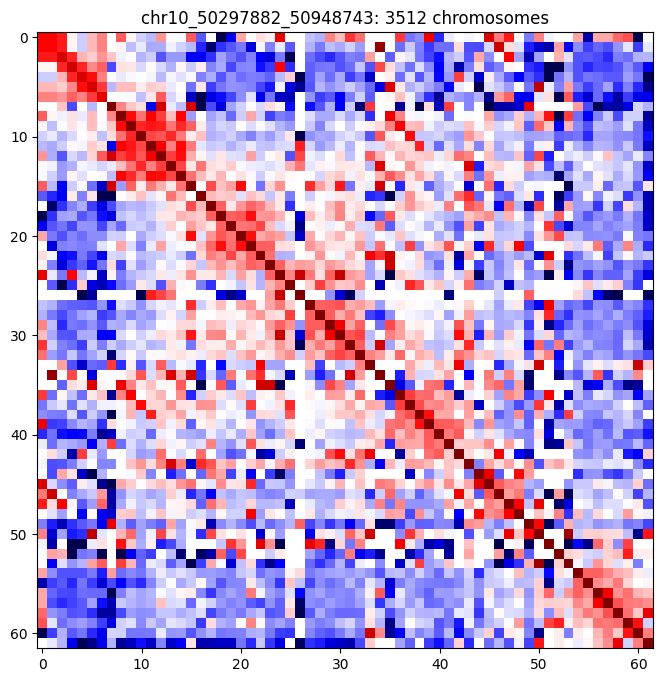

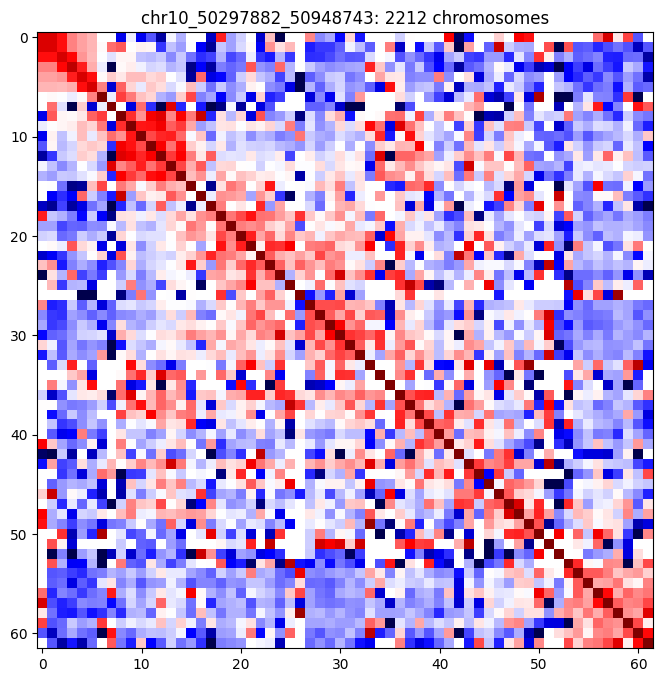

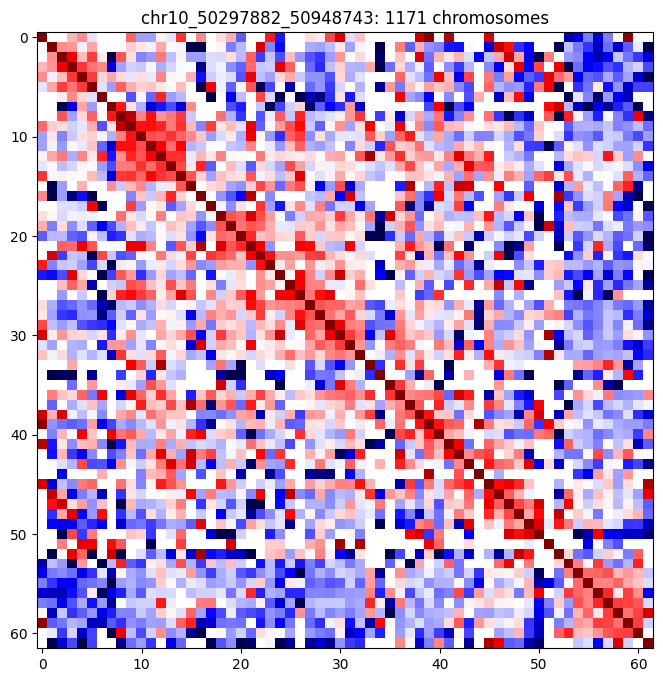

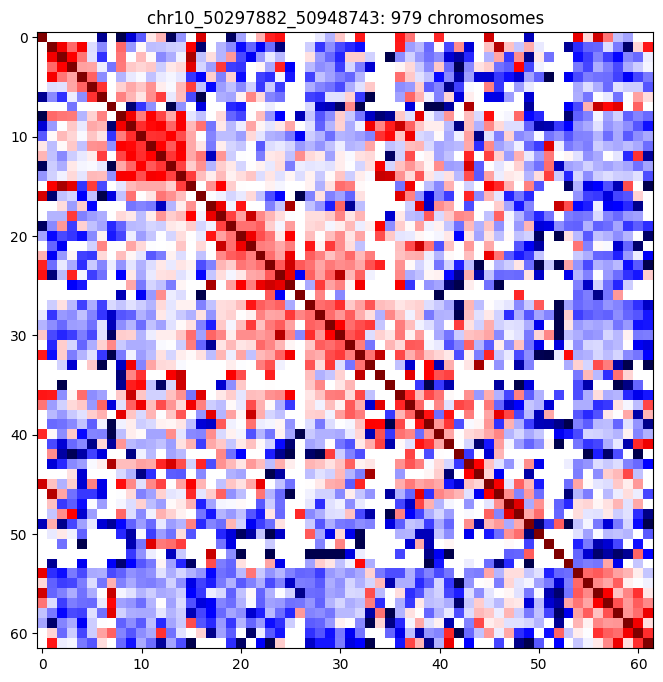

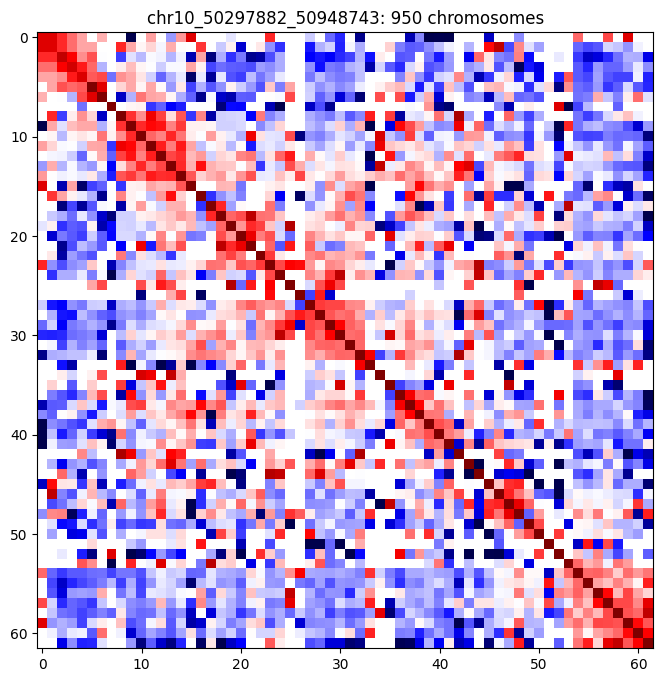

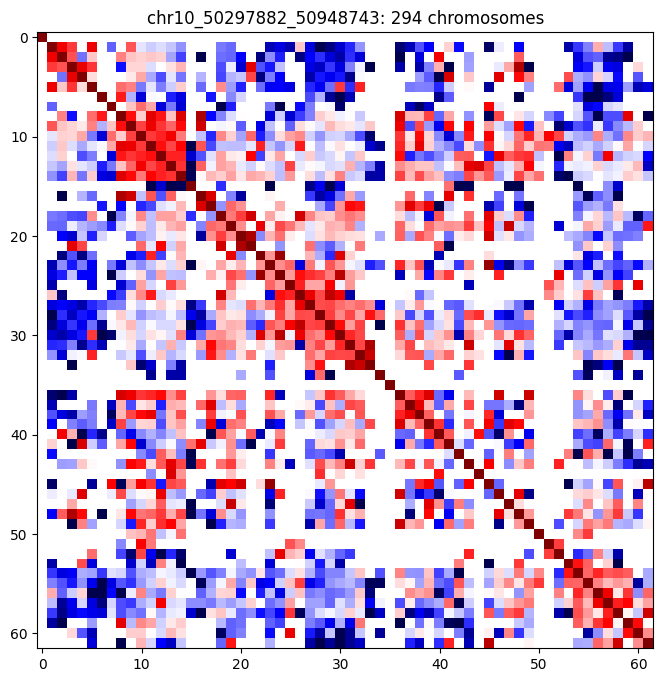

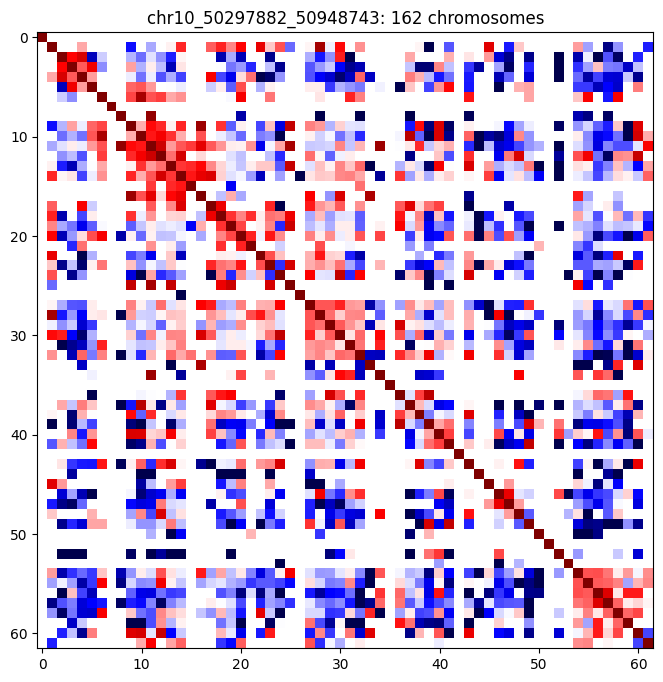

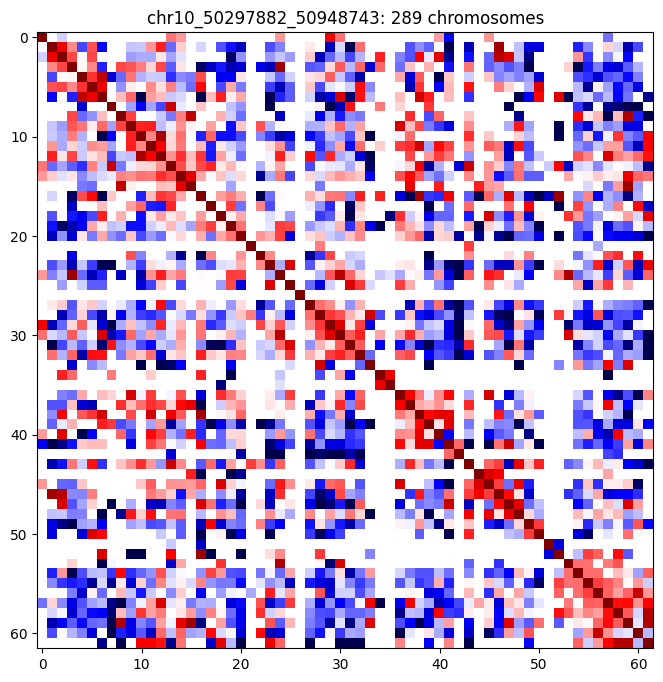

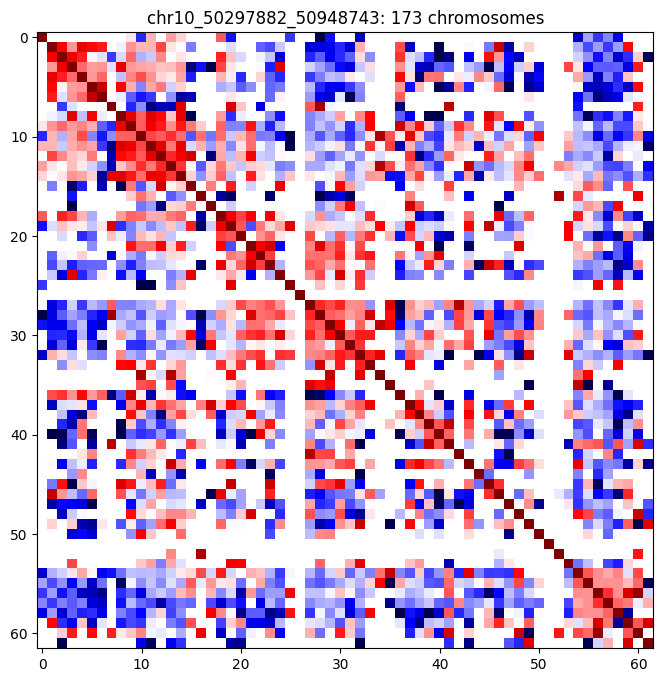

In [18]:
from scipy.spatial.distance import pdist,squareform

show_eff = False
# load in the aggregate heatmap
th_score = -1.2

for loc in locs[0:1]:
    
    trace_fls = glob.glob(finedrifts_folder+os.sep+r'*_XHfs_finedrft_'+loc+'_traces.npz')
    size = None
    zxys_f,scores_f, cids_f = None,None,None
    for tr_fl in trace_fls:
        dic_ = np.load(tr_fl)
        zxys_f_ = dic_['zxys_f']
        scores_f_ = dic_['scores_f']
        
        if size != None and zxys_f_.shape[1] != size:
            continue
        zxys_f = zxys_f_ if zxys_f is None else np.concatenate([zxys_f,zxys_f_])
        size = zxys_f.shape[1]
        scores_f = scores_f_ if scores_f is None else np.concatenate([scores_f,scores_f_])
        cids_f_ = dic_['cells_f']
        cids_f_ = [ str(int(x)//100000)+'_'+str(int(x)%100000) for x in cids_f_ ]
        cids_f = cids_f_ if cids_f is None else np.concatenate([cids_f,cids_f_])
        
    Xf = np.array(zxys_f)
    bad = np.log(scores_f)<th_score
    Xf[bad] = np.nan

    if False: ### correct chromatic abberation (lazy)
        ncol=3
        cm = np.nanmean(Xf[:,:,:],axis=1)[:,np.newaxis]
        for icol in range(ncol):
            Xf[:,icol::ncol,:]-=np.nanmedian(Xf[:,icol::ncol,:],axis=1)[:,np.newaxis]+cm

    for cluster in cluster_locs.keys():

        # compute the distances and matrices for given cluster
        cluster_cids = cluster_locs[cluster]
        if len(cluster_cids) < 100:
            continue
        cluster_Xf = Xf[np.where([x in cluster_cids for x in cids_f])]
        cluster_mats = np.array([squareform(pdist(X_)) for X_ in cluster_Xf])
        print(cluster_cids.shape[0])

        if show_eff:
            # plot detection efficiencies per cluster for cell and by round.
            det_eff_per_chr = (1-np.mean(np.isnan(cluster_Xf[:,:,-1]),axis=-1))
            plt.figure()
            plt.hist(det_eff_per_chr,bins=20)
            
            plt.figure()
            det_eff_per_rnd = (1-np.mean(np.isnan(cluster_Xf[:,:,-1]),axis=0))
            plt.plot(det_eff_per_rnd)
        
        plt.figure(figsize=(8,8))
        smoothed_image = cv2.blur(np.nanmedian(cluster_mats,0), ksize=(2,2))
        smoothed_image[np.where(np.isnan(smoothed_image))] = np.nanmedian(cluster_mats,0)[np.where(np.isnan(smoothed_image))]
        plt.imshow(smoothed_image, vmax=0.9,vmin=0.0,cmap='seismic_r')
        plt.title(loc+': '+str(cluster_mats.shape[0])+' chromosomes')
        

<h3> This code is to load in Day 3 and Day 14 chromatin structures and compare them to each other. Uses .npy matrices taken from the earlier steps of this notebook </h3>

In [129]:
locs

['chr10_50297882_50948743',
 'chr11_22408906_22969049',
 'chr12_75004739_75484764',
 'chr17_28708688_29359137',
 'chr19_1202064_1844826',
 'chr19_3708256_4213167',
 'chr19_37547865_38078198',
 'chr1_196891040_197431282',
 'chr1_68955457_69504871',
 'chr20_38815572_39295315',
 'chr2_165422331_165922285',
 'chr2_185057219_185537559',
 'chr2_28976364_29446381',
 'chr3_199135617_199702565',
 'chr4_149682600_150182502',
 'chr4_83436934_83946704',
 'chr5_174406074_174886658',
 'chr6_89108309_89608298',
 'chr7_20125023_20755624',
 'chr8_113098273_113597929',
 'chr8_144292244_144677239',
 'chr8_145231416_145720916',
 'chr8_79992471_80482456',
 'chr9_37910438_38580724',
 'chrX_109291856_109931988']

C:\Users\cfg001\AppData\Local\Temp\ipykernel_25372\4275207792.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


chr10_50297882_50948743


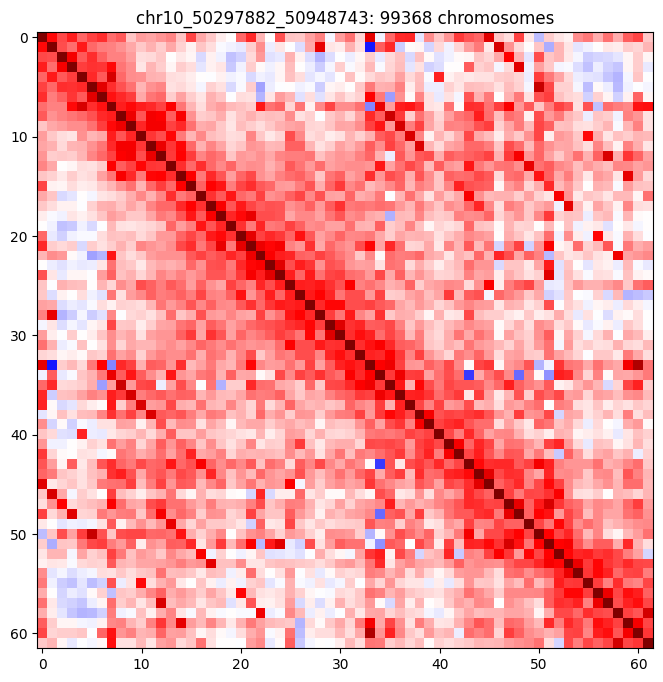

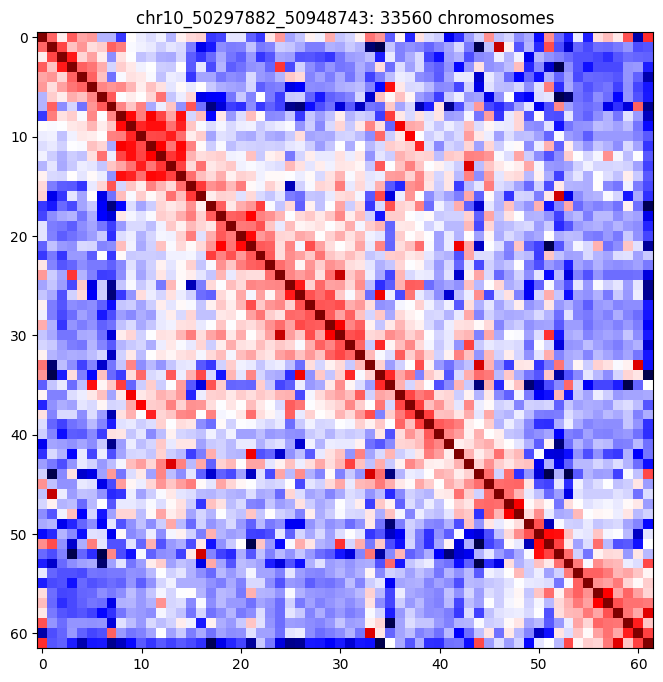

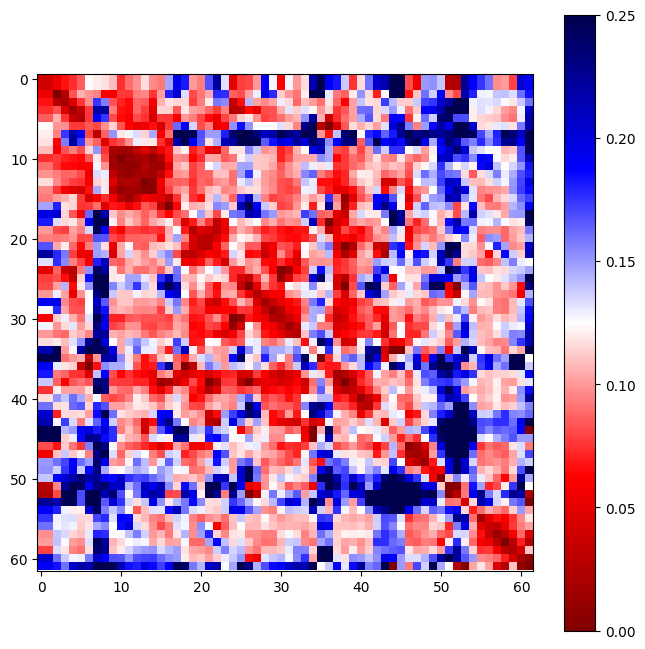

In [23]:
from scipy.ndimage.filters import gaussian_filter 

for loc in locs[:1]:
    
    day3 = np.load(r'Z:\Adam\E200_WTC11_WTday3__8_31_2023\best_per_cellComb\heatmaps'+os.sep+loc+'_traces.npy')
    day14 = np.load(r'Z:\Adam\E201_WTC11_WTday15__10_20_2023\best_per_cellComb_3000th_5_5th_h\heatmaps'+os.sep+loc+'_traces.npy')
    
    plt.figure(figsize=(8,8))
    print(loc)
    plt.imshow(np.nanmedian(day3,0),vmax=0.9,vmin=0.0,cmap='seismic_r')
    plt.title(loc+': '+str(day3.shape[0])+' chromosomes')
    
    plt.figure(figsize=(8,8))
    keep = np.arange(day3.shape[1])#[icol::3]
    plt.imshow(np.nanmedian(day14,0),vmax=0.9,vmin=0.0,cmap='seismic_r')
    plt.title(loc+': '+str(day14.shape[0])+' chromosomes')
    
    difference = (np.nanmedian(day14,0)-np.nanmedian(day3,0))
    plt.figure(figsize=(8,8))
    smoothed_image = cv2.blur(difference, ksize=(2,2))
    smoothed_image[np.where(np.isnan(smoothed_image))] = difference[np.where(np.isnan(smoothed_image))]
    plt.imshow(smoothed_image, cmap='seismic_r', vmin=-0.0, vmax=0.25)
    plt.colorbar()